# Alzheimer & MCI DeepLearning(CNN) Classifier
- ADNI MRI 이미지로 알츠하이머와 경도인지장애를 분류하는 딥러닝 프로젝트
- 데이터 출처
  - 메타데이터 : https://ida.loni.usc.edu/
  - MRI이미지 : https://www.kaggle.com/datasets/katalniraj/adni-extracted-axial
- 저작권에 의해 데이터는 깃허브에 업로드 하지 않았음

## Part3-1. Final model Training & Evaluation
- 본 작업은 로컬환경(VScode)에서 진행되었음.
- 로컬 가상 환경(Conda)
  - OS : Windows11
  - Python version : 3.9
  - Packages : requirments.txt로 설치하여 진행하였음
  - Tensorflow version : 2.7

### 1. Library & Data Import

- Library Import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

- Directory 지정 & 폴더 확인

In [2]:
base_dir = "./imagedata/"
data_dir = base_dir + "Axial"

os.listdir(data_dir)

['AD', 'CN', 'MCI']

- Global 변수 지정
  - 이전 노트와 동일하게 설정
  - 클래스 순서, 이미지 크기(256), 배치사이즈(32), 채널(3), 에포크(10), 시드(42)

In [3]:
CLASSES = ['CN', 'MCI', 'AD']
IMG_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
SEED = 42

- Image Data 수 확인

In [4]:
number_of_images = {}
for class_name in CLASSES:
    number_of_images[class_name] = len(os.listdir(data_dir+"/"+class_name))
image_count_df = pd.DataFrame(number_of_images.values(),
                              index=number_of_images.keys(),
                              columns=["Number of Images"])
display(image_count_df)
print("\nSum of Images: {}".format(image_count_df.sum()[0]))

,Number of Images
CN,1440
MCI,2590
AD,1124



Sum of Images: 5154


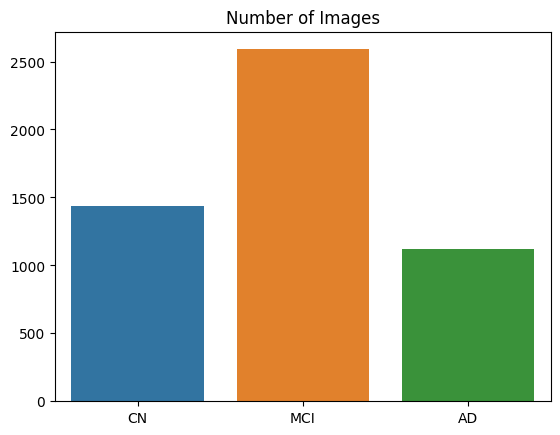

In [5]:
sns.barplot(data=image_count_df.T)
plt.title("Number of Images")
plt.show()

- Data 불러오기

In [6]:
dataset = image_dataset_from_directory(
    data_dir,
    shuffle=True,
    class_names=CLASSES,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    seed=SEED
)
print(dataset.class_names)

Found 5154 files belonging to 3 classes.
['CN', 'MCI', 'AD']


### 2. Data Split & Prefetch

- Data Split
  - Train : Validation : Test = 0.8 : 0.1 : 0.1
  - Batch 단위로 묶인 데이터라 Batch단위로 Split

In [7]:
def dataset_split(ds, tr=0.8, val=0.1, test=0.1, shuffle=True, buf_size=10000, SEED=42):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(buf_size,seed=SEED)
  train_size = int(ds_size*tr)
  val_size = int(ds_size*test)
  
  train = ds.take(train_size)
  test0 = ds.skip(train_size)
  val = test0.take(val_size)
  test = test0.skip(val_size)

  return train,val,test

train_ds, val_ds, test_ds = dataset_split(dataset)
print("Split전 Batched data 개수")
print(f"Dataset : {len(dataset)}")
print("\nSplit후 Batched data 개수")
print(f"Train : {len(train_ds)}")
print(f"Validation : {len(val_ds)}")
print(f"Test : {len(test_ds)}")

Split전 Batched data 개수
Dataset : 162

Split후 Batched data 개수
Train : 129
Validation : 16
Test : 17


- Data Prefetch
  - 속도를 향상시키기 위한 목적

In [8]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### 3. Final model Training

- 튜닝 후 저장했던 Model을 불러와(Decoding) 학습 진행
- layer 정보
  - sequential layer : 정규화 layer
    - Resizing : (256, 256)으로 크기 맞춤
    - Rescaling : 0~255의 데이터를 0~1로 정규화
  - sequential_1 layer : 데이터 증강 layer, Train dataset에만 적용
    - RandomFlip : 수직, 수평으로 데이터를 뒤집어 훈련데이터를 증강
    - RandomRotation : 0.1정도를 Random하게 기울여 훈련데이터를 증강
  - CNN 모델
    - 데이터 특징 추출 layer (Feature Extractor)
      - Conv2D, MaxPooling2D로 이루어진 2개의 블럭(Block)
      - Conv2D
        - 필터(filter size) : 3x3
        - 풀링(pooling) : same
        - 활성화 함수 : relu
        - 출력 차원수(Filters) : 16
      - MaxPooling2D : 2x2
    - 데이터 분류 layer (Classifier)
      - Flatten으로 펼침
      - 1개의 은닉층(노드수=320, 활성화함수=relu)
      - 다중 분류 출력층(노드수=3, 활성화함수=softmax)
- 모델 컴파일(compile)
  - Optimizer : Adam
  - 손실함수 (Loss function) : Sparse Categorical Crossentropy
  - 평가지표 (Metrics) : Accuracy

In [9]:
model_path = base_dir + "model_tuned.hdf5"
model = load_model(filepath=model_path)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 256, 256, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 128, 128, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 128, 128, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 64, 64, 16)         0         
 2D)                                                  

- Model Compile

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

### 4. Training Model (fit)

- Callback 함수 지정
  - EarlyStopping
    - 성능 개선 기준 epoch (patience) : 5
  - ModelCheckpoint
    - 모델 저장 기준 (monitor) : Validation Loss
    - save_best_only : True

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_save_path = base_dir + "/best_model.hdf5"
checkpointer = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', verbose=0, save_best_only=True)

- Model Fit
  - EarlyStopping 적용하기 때문에 Epoch는 충분하게 100으로 지정
    - EPOCHS = 10*10

In [12]:
history1 = model.fit(
    train_ds,
    epochs = EPOCHS*10,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    callbacks=[early_stop, checkpointer]
)

Epoch 1/100
129/129 [==============================] - 45s 300ms/step - loss: 1.3425 - acc: 0.5056 - val_loss: 0.9541 - val_acc: 0.5352
Epoch 2/100
129/129 [==============================] - 37s 290ms/step - loss: 0.9006 - acc: 0.5841 - val_loss: 0.8533 - val_acc: 0.6016
Epoch 3/100
129/129 [==============================] - 37s 290ms/step - loss: 0.7616 - acc: 0.6589 - val_loss: 0.6957 - val_acc: 0.6973
Epoch 4/100
129/129 [==============================] - 37s 290ms/step - loss: 0.6528 - acc: 0.7180 - val_loss: 0.5605 - val_acc: 0.7715
Epoch 5/100
129/129 [==============================] - 38s 294ms/step - loss: 0.5337 - acc: 0.7800 - val_loss: 0.4240 - val_acc: 0.8438
Epoch 6/100
129/129 [==============================] - 37s 284ms/step - loss: 0.4423 - acc: 0.8258 - val_loss: 0.4646 - val_acc: 0.8320
Epoch 7/100
129/129 [==============================] - 38s 292ms/step - loss: 0.3544 - acc: 0.8609 - val_loss: 0.2646 - val_acc: 0.9102
Epoch 8/100
129/129 [===========================

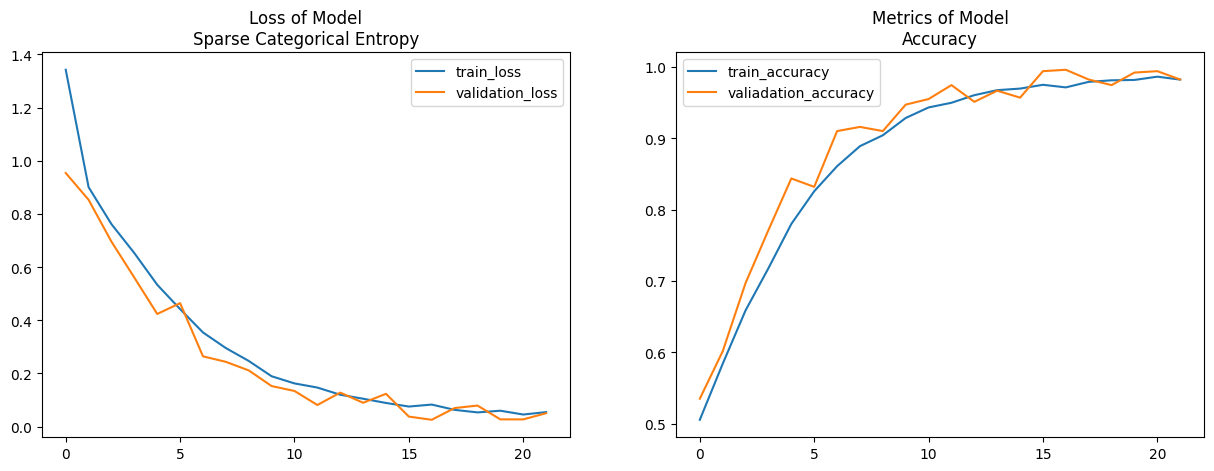

In [13]:
loss1 = history1.history['loss']
acc1 = history1.history['acc']
val_loss1 = history1.history['val_loss']
val_acc1 = history1.history['val_acc']

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(loss1, label="train_loss")
plt.plot(val_loss1, label="validation_loss")
plt.title("Loss of Model\nSparse Categorical Entropy")
plt.legend()

plt.subplot(122)
plt.plot(acc1, label="train_accuracy")
plt.plot(val_acc1, label="valiadation_accuracy")
plt.title("Metrics of Model\nAccuracy")
plt.legend()

plt.show()

### 5. Evaluation (일반화 가능성 확인)

- 마지막 Epoch로 evaluation

In [14]:
model.evaluate(test_ds, verbose=1)

17/17 [==============================] - 10s 63ms/step - loss: 0.0816 - acc: 0.9743


[0.08163662254810333, 0.9742646813392639]

- EarlyStopping으로 저장된 Best Model로 evaluation 

In [16]:
model_best = load_model(filepath=model_save_path)
test_loss, test_acc = model_best.evaluate(test_ds, verbose=1)
print(f"test loss : {test_loss}")
print(f"test accuracy : {test_acc}")

17/17 [==============================] - 1s 65ms/step - loss: 0.0502 - acc: 0.9853
test loss : 0.05021626874804497
test accuracy : 0.9852941036224365


- 일반화 가능성 시각화

In [23]:
# val_loss 최소값, 인덱스 확인
print(np.min(val_loss1))
print(np.argmin(val_loss1))
print(np.argmin(val_loss1)-len(val_loss1))

0.025903187692165375
16
-6


In [26]:
# 인덱스 16 혹은 -6이 최적화된 값이므로 이를 dataframe으로 만들기
train_l_m = [loss1[-6], acc1[-6]]
val_l_m = [val_loss1[-6], val_acc1[-6]]
test_l_m = [test_loss, test_acc]
loss_acc_dict = dict(zip(['train', 'validation', 'test'], [train_l_m, val_l_m, test_l_m]))
loss_acc_df = pd.DataFrame(loss_acc_dict, index=['loss','accuracy'])
loss_acc_df

,train,validation,test
loss,0.083077,0.025903,0.050216
accuracy,0.971415,0.996094,0.985294


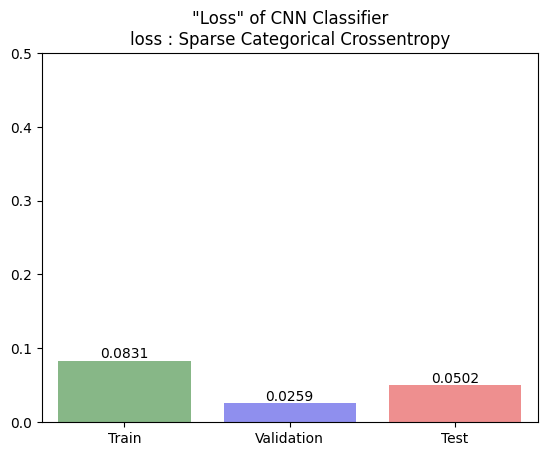

In [41]:
loss_dict = dict(zip(['Train','Validation','Test'], [loss1[-6], val_loss1[-6], test_loss]))
loss_df = pd.DataFrame(loss_dict, index=['loss'])
loss_bar = sns.barplot(data=loss_df.round(4), palette=['green', 'blue', 'red'], alpha=0.5)
loss_bar.bar_label(loss_bar.containers[0])
plt.title('"Loss" of CNN Classifier\nloss : Sparse Categorical Crossentropy')
plt.ylim(0.0, 0.5)
plt.show()

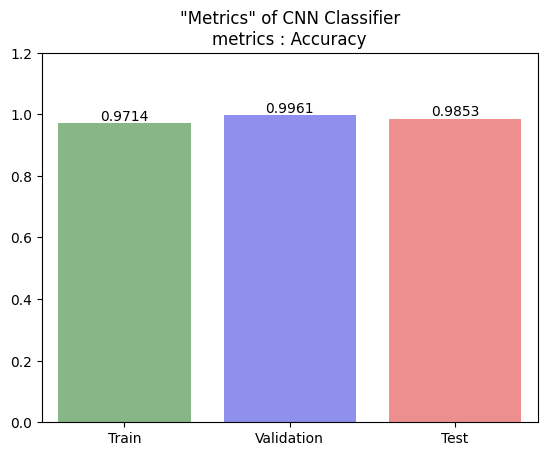

In [42]:
acc_dict = dict(zip(['Train','Validation','Test'], [acc1[-6], val_acc1[-6], test_acc]))
acc_df = pd.DataFrame(acc_dict, index=['acc'])
acc_bar = sns.barplot(data=acc_df.round(4), palette=['green', 'blue', 'red'], alpha=0.5)
acc_bar.bar_label(acc_bar.containers[0])
plt.title('"Metrics" of CNN Classifier\nmetrics : Accuracy')
plt.ylim(0, 1.2)
plt.show()

### 6. Model Prediction (테스트 데이터셋 예측결과 시각화)
- 최종 모델이 제대로 예측 하는지 확인하기 위해 시각화 진행
- Part3-2에서 다시 자세하게 다룰 예정

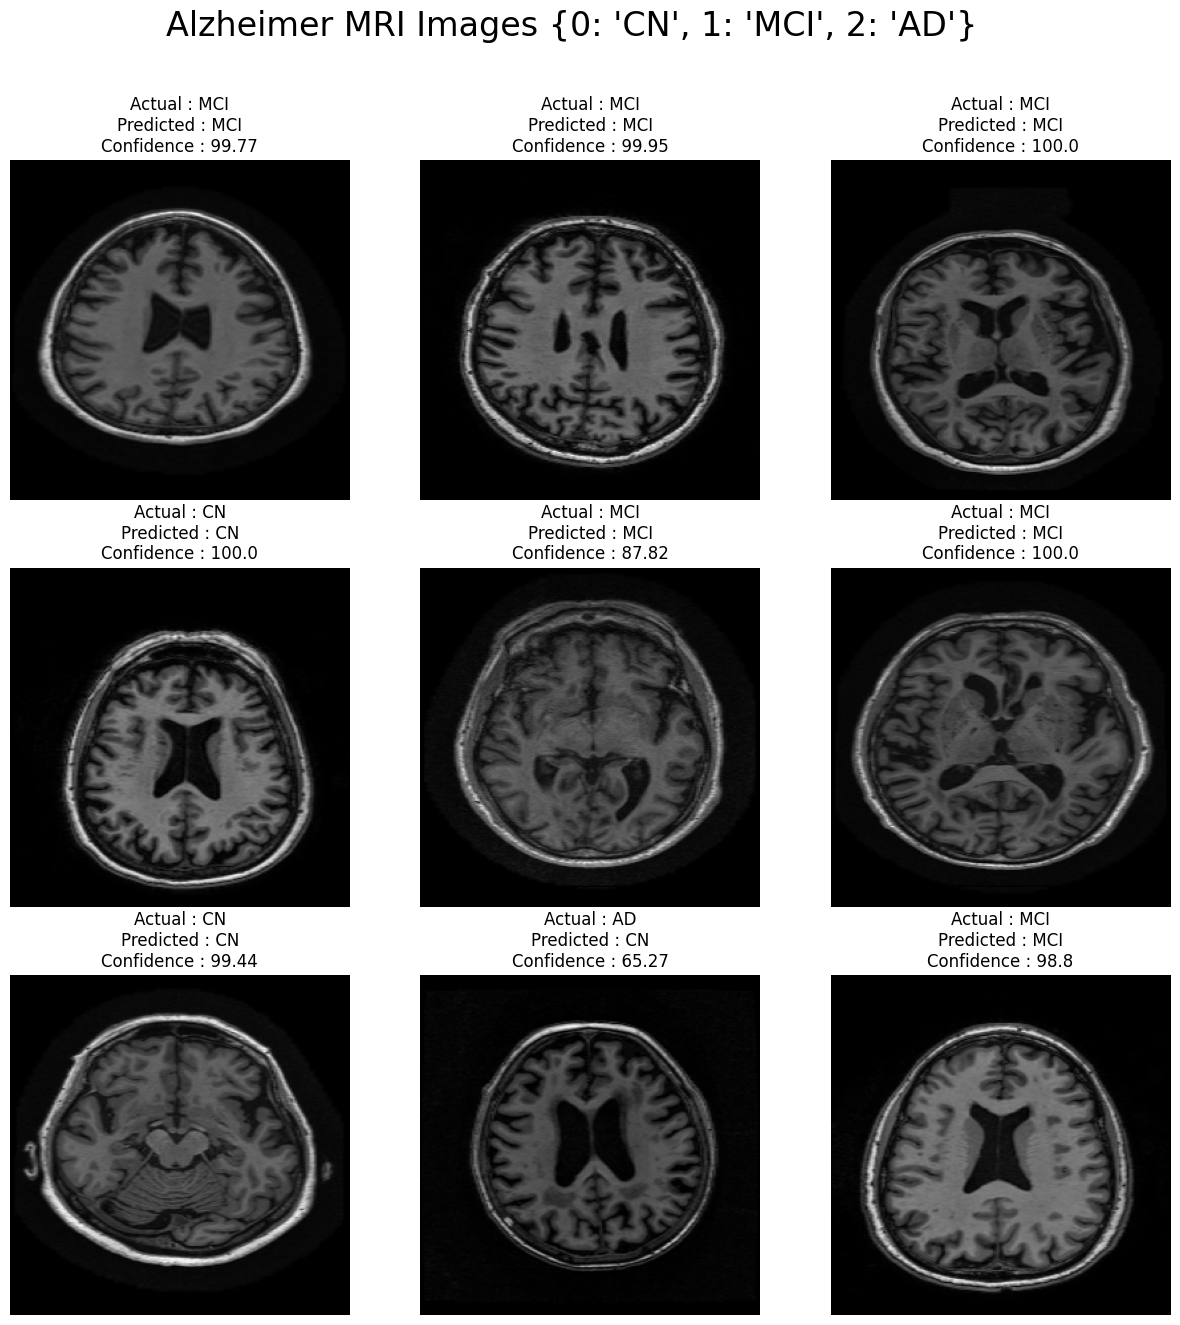

In [43]:
def prediction(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, axis=0)
  
  predictions = model.predict(img_array, verbose=0)

  predicted_class = CLASSES[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), ndigits=2)

  return predicted_class, confidence

class_dict = dict(zip([0,1,2],dataset.class_names))
plt.figure(figsize=(15,15))
plt.suptitle(f"Alzheimer MRI Images {class_dict}", fontsize=24)
for image_test, label_test in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_test[i].numpy().astype("uint8"))
    predicted_class, confidence = prediction(model_best, image_test[i].numpy())
    lab_true = CLASSES[label_test[i].numpy()]
    plt.title("Actual : {}\nPredicted : {}\nConfidence : {}".format(lab_true, predicted_class, confidence))
    plt.axis("off")

## Part 3-2
- 저장 된 모델들이 다시 불러와도 제대로 작동하는지 확인하기 위해 다음 노트에서 예측 및 시각화를 진행할 것임 
- 튜닝 전에 저장한 CNN모델과 튜닝 후에 저장한 최종CNN모델을 시각화하고 비교분석을 진행할 예정

- Part3-2. Plotting & Prediction
  - 튜닝 전후 모델 시각화 및 비교분석